# Chapter 13. 최대우도추정 (Maximum Likelihood Estimates (MLEs))


다음을 계산한다. :
1. 정규분포의 MLE 계산
2. 지수분포의 MLE 계산
3. MLE 를 이용하여 asset returns 에 정규분포를 Fit

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats

## 정규분포 (Normal Distribution)

연속확률분포중 평균에 가까울수록 발생확률이 높아질 경우 정규분포 사용.

정규분포 sample data 생성

In [3]:
TRUE_MEAN = 40
TRUE_STD = 10
X = np.random.normal(TRUE_MEAN, TRUE_STD, 1000)

위에서 만들어진 data 를 가지고  위 정규분포의 $\mu$ 와 $\sigma$ 를 parameter 로 하여 MLE 를 계산하는 함수를 정의한다.

$$\hat\mu = \frac{1}{T}\sum_{t=1}^{T} x_t$$ 이므로

$$\hat\sigma = \sqrt{\frac{1}{T}\sum_{t=1}^{T}{(x_t - \hat\mu)^2}}$$ 이다.

In [4]:
def normal_mu_MLE(X):
    T = len(X)       # 표본 X의 수 T
    s = sum(X)     # 표본 X의 합계 s
    return 1.0/T * s     # 표본 X 의 평균

def normal_sigma_MLE(X):
    T = len(X)
    mu = normal_mu_MLE(X)               # 표본 X 의 평균
    s = sum( np.power((X - mu), 2) )    # 평균과 표본의 오차 제곱
    sigma_squared = 1.0/T * s              #  sigma^2
    return math.sqrt(sigma_squared)     # sigma

sample data 를 가지고 우리가 만든 함수에서 계산된 값과 np.mean, np.std 에서 계산한 값 비교. 같음을 확인.

In [5]:
print("Mean Estimation")
print(normal_mu_MLE(X))        # 우리가 만든 함수로 계산한 평균
print(np.mean(X))                    # np.mean
print("Standard Deviation Estimation")
print(normal_sigma_MLE(X))     # 우리가 만든 함수로 계산한 std
print(np.std(X))                       # np.std

Mean Estimation
39.836149621719336
39.83614962171926
Standard Deviation Estimation
10.10959890892192
10.109598908921916


이번에는 scipy 에서 제공하는 fit() 함수로 계산하여 역시 같음을 확인.

In [6]:
mu, std = scipy.stats.norm.fit(X)
print("mu estimate: " + str(mu))
print("std estimate: " + str(std))

mu estimate: 39.83614962171926
std estimate: 10.109598908921916


sample data 의 PDF(probability density function 을 그려서 얼마나 잘 맞는지 확인. scipy.stats.norm.pdf 를 이용.

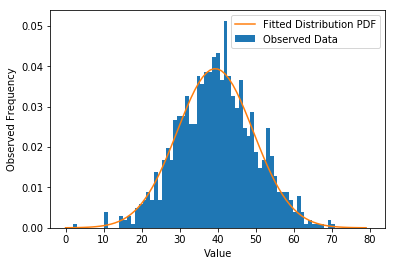

In [7]:
pdf = scipy.stats.norm.pdf
# sample data X 를  0-80 사이의 x 축에 80 개 interval(bin) 으로 plot (mean 이 40 이므로)
# (increments of 1)
x = np.linspace(0, 80, 80)
plt.hist(X, bins=x, density='true')
plt.plot(pdf(x, loc=mu, scale=std))
plt.xlabel('Value')
plt.ylabel('Observed Frequency')
plt.legend(['Fitted Distribution PDF', 'Observed Data', ]);

## 지수분포(Exponential Distribution)

연속확률분포중 시간이 지날수록 발생할 확률이 점점 작아지는 경우 지수분포 사용. 지수분포는 프아송분포와 관련 있으므로 프아송분포의 대표적인 기호 $\lambda$ 를 사용. ($\lambda$ : 정해진 시간 안에 어떤 사건이 일어날 횟수에 대한 기댓값)

동일한 작업을 지수분포에 대해 수행. sample data 작성부터 시작.

In [10]:
TRUE_LAMBDA = 5
X = np.random.exponential(TRUE_LAMBDA, 1000)

`numpy` 는 지수분포를 다음과 같이 정의
$$\frac{1}{\lambda}e^{-\frac{x}{\lambda}}$$

So we need to invert the MLE from the lecture notes. There it is

$$\hat\lambda = \frac{T}{\sum_{t=1}^{T} x_t}$$

Here it's just the reciprocal, so

$$\hat\lambda = \frac{\sum_{t=1}^{T} x_t}{T}$$

In [8]:
def exp_lamda_MLE(X):
    T = len(X)
    s = sum(X)
    return s/T

In [9]:
print("lambda estimate: " + str(exp_lamda_MLE(X)))

lambda estimate: 39.836149621719336


In [10]:
# The scipy version of the exponential distribution has a location parameter
# that can skew the distribution. We ignore this by fixing the location
# parameter to 0 with floc=0
_, l = scipy.stats.expon.fit(X, floc=0)

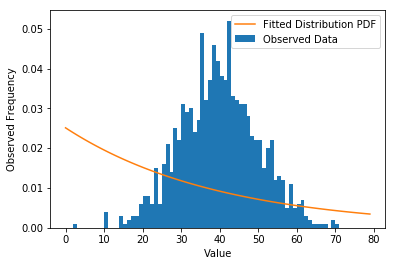

In [12]:
pdf = scipy.stats.expon.pdf
x = range(0, 80)
plt.hist(X, bins=x, density='true')
plt.plot(pdf(x, scale=l))
plt.xlabel('Value')
plt.ylabel('Observed Frequency')
plt.legend(['Fitted Distribution PDF', 'Observed Data', ]);

### MLE for Asset Returns

실제 주식의 return 을 MLE 를 이용하여 정규분포에 맞추어 본다.

In [16]:
from googlefinance.client import get_price_data, get_prices_data
import pandas as pd

param_AAPL = {
    'q': "TSLA", # Stock symbol (ex: "AAPL")
    'i': "86400", # Interval size in seconds ("86400" = 1 day intervals)
    'x': "NASD", # Stock exchange symbol on which stock is traded (ex: "NASD")
    'p': "10Y" # Period (Ex: "1Y" = 1 year)
}
df = pd.DataFrame(get_price_data(param_AAPL))
df.index = df.index.date
df.index = pd.to_datetime(df.index)

start = pd.to_datetime('2014-01-01')
end = pd.to_datetime('2015-01-01')
prices = df['Close'].loc[start : end]

absolute_returns = np.diff(prices)       # 매일의 dollar return 
# 전날 가격에 대한 수익률 계산 
# [:-1] 로 하면 마지막날 data 만 제외하고 계산됨 (마지막날은 return 이 없으므로)
returns = absolute_returns/prices[:-1]   

`scipy` 의 fit 함수를 이용하여 $\mu$ 와 $\sigma$ MLE 를 구함.

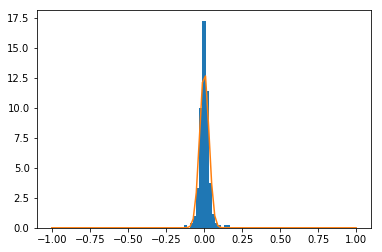

In [18]:
mu, std = scipy.stats.norm.fit(returns)
pdf = scipy.stats.norm.pdf
x = np.linspace(-1,1, num=100)
h = plt.hist(returns, bins=x, density='true')
l = plt.plot(x, pdf(x, loc=mu, scale=std))

물론, return 의 분포가 정규분포를 따르지 않는다면 이 fit 은 의미가 없다. 자크베라 정규성 검사를 통해 테스트할 수 있다. 자크베라 테스트는 p-value 가 c 보다 낮으면 정규분포라는 가설을 reject 한다.

In [19]:
from statsmodels.stats.stattools import jarque_bera
jarque_bera(returns)

(253.6341633259662, 8.3953967079954e-56, 0.7542970128055636, 7.677582566707229)

두번째 return 값이 pvalue 이고 4 번째 값이 kurtosis 인데, pvalue 가 0.05 보다 작고 kurtosis 가 3 이 아니므로 return 의 분포는 정규성을 가지지 않는다.

In [21]:
jarque_bera(np.random.normal(0, 1, 100))

(1.4817897301029048,
 0.4766871539279691,
 0.11560106100506587,
 3.5497045697487963)

test data 의 경우 pvalue 가 0.05 보다 크고 kurtosis 가 3 에 가까우므로 정규분포이다.